# Modello Bert per NLP

L'obiettivo del progetto è cercare di prevedere, attraverso tecniche di NLP e classificazione, se i tweet dei seguenti dataset parlano realmente di un disastro oppure no. Per farlo abbiamo utilizzato 3 dataset:


*   train.csv
*   test.csv
*   sample_submission.csv



In [ ]:
!pip install keras-nlp --quiet
!pip install keras-core --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.6 MB/s eta 0:00:00


In [ ]:
import string
import re
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras_core as keras
import keras_nlp
from transformers import BertTokenizer, BertForSequenceClassification


from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))





Using TensorFlow backend


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Come primo step abbiamo importato diverse librerie che vengono utilizzate per lavorare con stringhe, applicare espressioni regolari (ad esempio per rimuovere punteggiatura o caratteri non desiderati) e contare le frequenze di elementi come parole o caratteri. NumPy è la libreria fondamentale per il calcolo scientifico con array e operazioni numeriche. Pandas invece viene usata per creare, analizzare e manipolare strutture dati come tabelle (DataFrame). Seaborn si basa su Matplotlib e fornisce grafici più ricchi e personalizzabili, soprattutto per l’analisi statistica. **TensorFlow** è un framework per la creazione e l’addestramento di modelli di deep learning. **Keras Core** è la versione modulare di Keras integrata con TensorFlow. **Keras NLP** aggiunge strumenti specifici per il linguaggio naturale, come tokenizzazione, modelli linguistici e preprocessing testuale. **BertTokenizer** invece converte il testo in una sequenza di token compatibile con il modello BERT. **BertForSequenceClassification** è un modello BERT già predisposto per attività di classificazione del testo.

In [ ]:
try:
  from google.colab import files
  g_colab= True
except:
  g_colab = False




file_name = "../train.csv"

if g_colab:
  uploaded = files.upload()
  import io
  uploaded_bytes = uploaded[list(uploaded.keys())[0]]
  train_data = pd.read_csv(io.BytesIO(uploaded_bytes))
else:
  train_data = pd.read_csv(file_name)

train_data

Saving train.csv to train.csv


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Importiamo il dataset train_data.


In [ ]:
try:
  from google.colab import files
  g_colab= True
except:
  g_colab = False



file_name = "../test.csv"

if g_colab:
  uploaded = files.upload()
  import io
  uploaded_bytes = uploaded[list(uploaded.keys())[0]]
  test_data = pd.read_csv(io.BytesIO(uploaded_bytes))
else:
  test_data = pd.read_csv(file_name)

test_data

Saving test.csv to test.csv


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


Applichiamo lo stesso procedimento con il test.csv

# Anlisi Esporativa dei Dati

Il dataset train è composto da diverse colonne:
id: unique identifier for each tweet.

*   keyword: parola chiave specifica del tweet (può essere vuoto).
*  location: posizione da cui è stato inviato il tweet (può essere vuoto).
*   text: testo del tweet.
*   target: indica se il tweet è un vero disastro (1) o meno (0).



In [ ]:
train_data.shape

(7613, 5)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# count NAN
train_data.isna().sum()


,0
id,0
keyword,61
location,2533
text,0
target,0


Il dataset è formato da 7613 righe e 5 colonne. Dando un primo sguardo al dataset notiamo che ci sono diversi valori nulli per gli attributi location, e keyword dopo aver contato i valori NA. Abbiamo quindi utilizzato una somma per contare quanti valori NAN sono presenti nel dataset per oogni attributo: location	2533,  keyword 61. Ignoriamo l'attributo location.


In [ ]:
test_data.shape

(3263, 4)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [ ]:
test_data.isna().sum()


,0
id,0
keyword,26
location,1105
text,0


Per il test_data la situazione è diversa. Per prima cosa il dataframe è formato da 3263 osservazioni e da 4 attiributi (manca la colonna "target"). Anche in questo dataset sono presenti valori NA, applichiamo ancora la somma di NAN. Gli attributi con maggiore NA sono keyword: 26 e location: 1105.

<ipython-input-4-79ab03a916ab>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Keyword', data=df_top_20_0, palette="Reds_d")


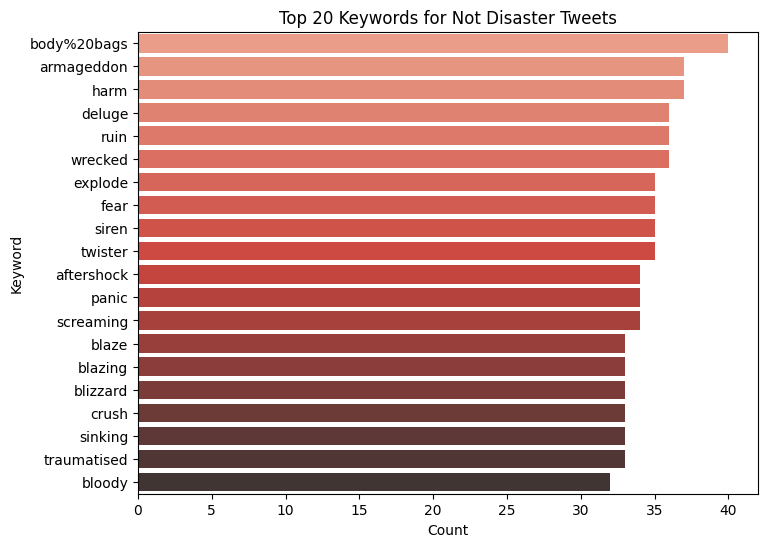

<ipython-input-4-79ab03a916ab>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Keyword', data=df_top_20_1, palette="Blues_d")


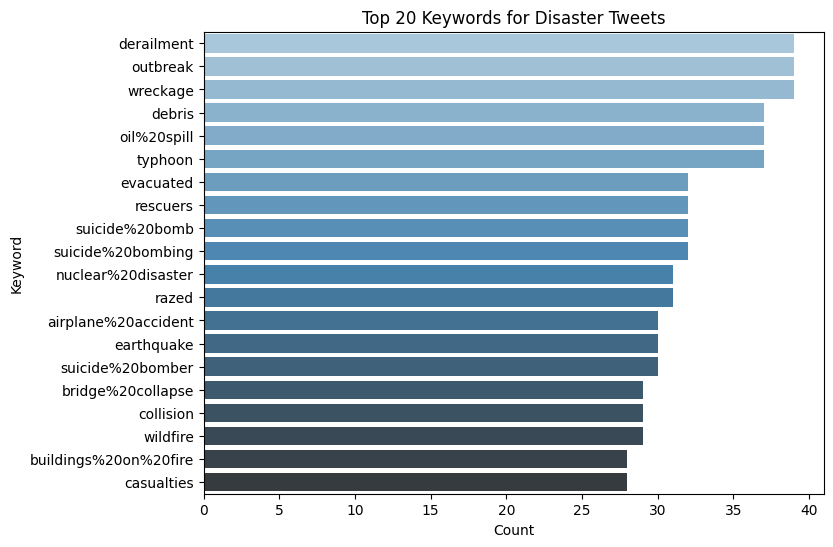

In [ ]:
df_filtered = train_data[train_data['keyword'].notnull()]

keywords_target_0 = df_filtered[df_filtered['target'] == 0]['keyword']
keywords_target_1 = df_filtered[df_filtered['target'] == 1]['keyword']

top_20_keywords_0 = Counter(keywords_target_0).most_common(20)
top_20_keywords_1 = Counter(keywords_target_1).most_common(20)

df_top_20_0 = pd.DataFrame(top_20_keywords_0, columns=['Keyword', 'Count'])
df_top_20_1 = pd.DataFrame(top_20_keywords_1, columns=['Keyword', 'Count'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Keyword', data=df_top_20_0, palette="Reds_d")
plt.title('Top 20 Keywords for Not Disaster Tweets')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Keyword', data=df_top_20_1, palette="Blues_d")
plt.title('Top 20 Keywords for Disaster Tweets')
plt.show()

Passiamo ad una prima visualizzazione dei dati, in particolare andiamo ad analizzare quali sono le prime 20 keyword utilizzate per tweet con disastri e non disastri. I grafici mostrano le prime 20 keyword più utilizzate nel dataset contenente i tweet con disastri, e tweet con non disastri.

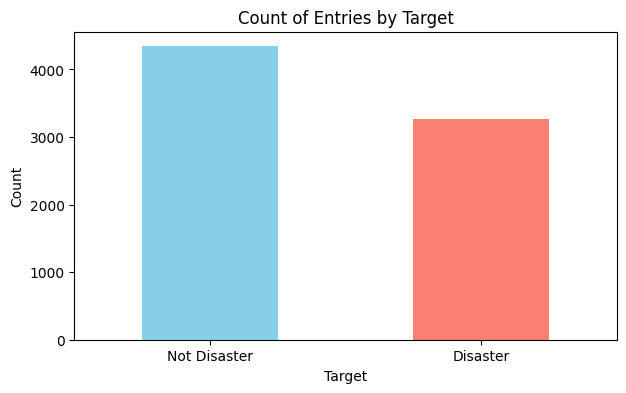

In [ ]:
target_counts = train_data['target'].value_counts()

plt.figure(figsize=(7, 4))
target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Entries by Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'], rotation=0)

plt.show()

Il barplot invece ci mostra il numero di Disastri e Non disastri presenti nell'attributo "Target". Il numero di non disastri è maggiore rispetto al numero di Disastri.

# Preprocessing dai dati

Prima di procede e metter mano al modello, cerchiamo di "pulire il dataset".

In [ ]:
duplicate_text = train_data[train_data["text"].duplicated(keep=False)]
unique_targets = duplicate_text.groupby('text').filter(lambda x: x["target"].nunique() != 1)
indices = unique_targets.index.tolist()

La prima riga di codice ci crea una variabile chiamata duplicate_text che si occupa di travare nell'attributo text valori duplicati, decidiamo di marcare i duplicati come TRUE. Successivamente facciamo un groupby per poi filtrare i gruppi di righe che hanno lo stesso valore in 'text', ma diversi valori in 'target'. nunique conta i valori unici che ci sono nella colonna 'target'. Se ce n’è più di uno (!= 1), vuol dire che quel testo è associato a più di un target diverso, in questo caso viene mantenuto il risultato.

In [ ]:
unique_targets.shape

(55, 5)

In [ ]:
unique_targets

,id,keyword,location,text,target
610,881,bioterrorism,NaN,To fight bioterrorism sir.,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
630,907,bioterrorism,NaN,To fight bioterrorism sir.,1
634,916,bioterrorism,NaN,To fight bioterrorism sir.,0
1197,1723,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,1
1214,1752,buildings%20burning,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,0
1221,1760,buildings%20burning,dallas,like for the music video I want some real acti...,1
1331,1922,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,0
1349,1950,burning%20buildings,dallas,like for the music video I want some real acti...,0
1365,1968,burning%20buildings,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,1


Indices contiene una lista degli indici "filtrati".

In [ ]:
zero_indices = [
    610, 630, 1197, 1221, 1365,
    2830, 2831, 2833,
    3243, 3248, 3985, 4221, 4232, 4239, 4292, 4305, 4312, 4318, 4320,
    4381, 5620, 6091, 6123, 6616
]


# Indici da aggiornare a 1
one_indices = [4618]

# Aggiornamento batch
train_data.loc[indices, 'target'] = 0
train_data.loc[one_indices, 'target'] = 1

Abbiamo agito manualmente (viste le dimensioni relativamente piccole del dataset 'unique_targets') e modificato i target dei seguenti indici. Questo anche per non idurre il modello ad essere alimentato da dati errati.

# Pulizia del testo
In questa sezione ci siamo occupati della pulizia del testo.

In [ ]:

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punctuation(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

def remove_numbers(text):
    return re.sub(r'[0-9]+', '', text)

def remove_empty_spaces(text):
    words = [word for word in text.split(" ") if (not word.strip() == "")]
    return " ".join(words)

def remove_stopwords(text):
    words = [word for word in text.split(" ") if word not in stop]
    return " ".join(words)



Il seguente codice che abbiamo sviluppato  definisce una serie di funzioni per la pulizia del testo, utili nel preprocessing di dataset testuali come quelli usati in NLP (Natural Language Processing). Ogni funzione prende in input una stringa e restituisce una versione "ripulita". Questa funzione invece rimuove gli URL dal testo. Usa un'espressione regolare per cercare stringhe che iniziano con http://, https:// o www. seguite da caratteri non spaziati. Tutti gli URL trovati vengono sostituiti con una stringa vuota.
Qui andiamo a rimuovere  i tag HTML presenti nel testo. L'espressione regolare '<.*?>' corrisponde a qualsiasi elemento HTML.  Questi  tag vengono eliminati lasciando solo il contenuto testuale.
Ora andiamo ad Eliminare  tutta la punteggiatura dal testo. L'espressione regolare mantiene solo lettere maiuscole e minuscole, numeri e spazi (\s). Tutti gli altri caratteri vengono rimossi.
Ora andiamo a rimuove tutti i numeri dal testo. Qualsiasi cifra, sia singola che in sequenza, viene sostituita da una stringa vuota.
Rimuoviamo spazi multipli o parole vuote. Il testo viene diviso in parole, e vengono filtrate solo quelle non vuote. Poi le parole vengono riunite con un singolo spazio tra loro.
Infine rimuoviamo le stopword (parole comuni e poco significative) dal testo. Il testo viene diviso in parole, e per ciascuna si verifica che non sia presente nel set stop, che deve essere stato precedentemente definito (solitamente usando nltk.corpus.stopwords). Le parole rimanenti vengono unite di nuovo in una stringa.












In [ ]:
#Funzione che pulisce il testo
def clean_text(text):
    text = text.lower()
    text = remove_url(text)
    text = remove_html(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_empty_spaces(text)
    text = remove_stopwords(text)
    return text


La funzione clean_text rappresenta un preprocessing completo per una stringa di testo. Lo scopo è quello di trasformare il testo in una forma "pulita" e standardizzata, utile per l'elaborazione nel contesto di NLP (Natural Language Processing), come la classificazione, il clustering o l’analisi del sentiment.
La funzione accetta una stringa come input.
La prima operazione converte tutto il testo in minuscolo, per evitare che parole identiche ma con maiuscole diverse vengano trattate come distinte.
Alla fine, la funzione restituisce il testo completamente ripulito.

In [ ]:
train_data["cleaned_text"] = train_data["text"].apply(clean_text)
test_data["cleaned_text"] = test_data["text"].apply(clean_text)

Questo codice mostra come applicare la funzione di pulizia clean_text ai dati contenuti nelle colonne text dei dataset train_data e test_data.
In questa riga si prende la colonna "text" del DataFrame train_data, che presumibilmente contiene il testo grezzo (ad esempio frasi, recensioni, messaggi, ecc.).
La funzione .apply(clean_text) applica la funzione clean_text a ciascuna riga della colonna, ovvero a ogni stringa di testo.
Il risultato viene salvato in una nuova colonna chiamata "cleaned_text" all’interno dello stesso DataFrame.
Alla fine, train_data conterrà sia il testo originale, sia la sua versione ripulita
Stessa identica logica viene applicata anche al DataFrame test_data.
Viene processata la colonna "text" con la funzione di pulizia clean_text e il risultato viene inserito in una nuova colonna chiamata "cleaned_text".





In [ ]:
train_data.head()

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


# Costruzione modello Bert

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5

La prima riga imposta di codice ci mostra  la dimensione del batch, ovvero il numero di campioni (righe del dataset) che il modello elabora alla volta durante l'addestramento.
In questo caso, il modello elaborerà 32 esempi per ogni "passaggio" (forward e backward propagation).

Un valore di batch più piccolo richiede meno memoria, ma può portare a un addestramento più instabile.
Un valore più grande è più stabile ma richiede più risorse e può impiegare più tempo per aggiornare i pesi.
Alla seconda riga di codice invece  si definisce il numero di epoche, cioè il numero di volte che il modello vedrà l'intero dataset durante l’addestramento.
Con EPOCHS = 5, l’algoritmo passerà 5 volte su tutti i dati disponibili.

Più epoche permettono al modello di apprendere meglio, ma un numero troppo alto può portare a overfitting, cioè un modello che impara troppo bene i dati di training e non generalizza bene su dati nuovi.
Insieme, questi due parametri controllano quanto a lungo e come il modello apprende dai dati.



In [ ]:
X = train_data["cleaned_text"]
Y = train_data["target"]
x_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

X_test = test_data["cleaned_text"]

Nella prima riga di codice si estrae dalla tabella train_data la colonna chiamata "cleaned_text" e la assegna alla variabile X.
X rappresenta quindi l’insieme delle feature, ovvero i dati di input, che in questo caso sono i testi già pre-elaborati.
Nella seconda riga invece viene estratta la colonna "target" dal dataset train_data, che contiene le etichette (o classi) associate a ciascun testo.
Questa sarà la variabile dipendente che il modello cercherà di prevedere durante l’addestramento.
La terza riga invece  utilizza la funzione train_test_split di Scikit-learn per suddividere il dataset in due parti:

x_train e y_train contengono rispettivamente i testi e le etichette da usare per addestrare il modello;

X_val e y_val contengono invece i dati da usare per la fase di validazione, cioè per verificare le prestazioni del modello su dati mai visti durante l’addestramento.

Il parametro test_size=0.2 indica che il 20% dei dati verrà riservato alla validazione, mentre l’80% verrà usato per il training.
Il parametro random_state=42 assicura che la suddivisione sia riproducibile, cioè sempre uguale se si esegue il codice più volte.

Infine, viene creata la variabile X_test contenente i dati testuali (già puliti) del dataset test_data, che saranno utilizzati per fare le predizioni finali, ad esempio in un contesto di competizione o valutazione su un set non etichettato.


In [ ]:


preset = "bert_base_en_uncased"

preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    preset=preset,
    sequence_length=160
)
classifier = keras_nlp.models.BertClassifier.from_preset(
    preset=preset,
    preprocessor=preprocessor,
    num_classes=2
)

classifier.summary()






100%|██████████| 510/510 [00:00<00:00, 413kB/s]


100%|██████████| 547/547 [00:00<00:00, 977kB/s]


100%|██████████| 226k/226k [00:00<00:00, 1.08MB/s]


100%|██████████| 418M/418M [00:08<00:00, 52.3MB/s]


Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     109,482,240 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 109,483,778 (417.65 MB)

 Trainable params: 109,483,778 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

Andiamo ad utilizzare  Keras NLP per costruire un modello di classificazione del testo basato su BERT (Bidirectional Encoder Representations from Transformers), partendo da un preset pre-addestrato.
Nella prima riga viene definito il preset del modello BERT da utilizzare.
Il valore "bert_base_en_uncased" indica una versione di BERT in inglese, di dimensione “base” (12 layer, 768 hidden size, 12 heads), e uncased, cioè che non distingue tra maiuscole e minuscole.
Questo pre-set fornisce il vocabolario, i pesi pre-addestrati e la configurazione del modello.
Nella seconda riga creiamo un preprocessore specifico per BERT, basato sul pre-set definito sopra.
Il preprocessore si occupa di:

tokenizzare il testo,

aggiungere i token speciali (come [CLS] e [SEP]),

eseguire il padding e il truncation alla lunghezza massima specificata.

La lunghezza della sequenza è impostata a 160 token, un valore adeguato per testi brevi o medi (ad esempio tweet, recensioni, brevi articoli).
In seguito creiamo un modello di classificazione basato su BERT, utilizzando sempre il preset specificato.
Il preprocessore viene passato al modello per assicurarsi che l’input venga preparato correttamente prima di essere elaborato.
Il parametro num_classes=2 indica che si tratta di un problema di classificazione binaria (ad esempio: positivo/negativo, vero/falso, spam/non-spam).

Il modello è già inizializzato con i pesi del BERT pre-addestrato e aggiunge una testa (head) di classificazione alla fine, che produce due output (uno per ciascuna classe)



In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=0

)




Il codice definisce una callback chiamata early_stopping, utilizzando tf.keras.callbacks.EarlyStopping di TensorFlow/Keras.

Le callback sono funzioni che vengono eseguite automaticamente in determinati momenti durante l'addestramento del modello, ad esempio alla fine di ogni epoca.

Questa in particolare serve a interrompere l’addestramento in anticipo se il modello smette di migliorare, evitando così di perdere tempo o peggiorare le prestazioni a causa dell'overfitting.

Andiamo adesso ad analizzare ciascun parametro:

monitor="val_loss"
Specifica la metrica da monitorare. In questo caso, si osserva l’errore di validazione (validation loss). Se questo non migliora più, si considera che l’addestramento possa essere fermato.

patience=2
Indica il numero di epoche consecutive da attendere senza miglioramenti prima di fermare l’addestramento. Qui si aspetteranno 2 epoche di fila senza miglioramento del val_loss prima di interrompere.

restore_best_weights=True
Dopo l’interruzione anticipata, il modello ripristinerà automaticamente i pesi migliori ottenuti durante l’addestramento, cioè quelli dell’epoca con il val_loss più basso.

verbose=0
Controlla la quantità di output visualizzato. In questo caso è impostato a 0, quindi non verranno stampati messaggi in console quando la callback si attiva
Questa callback è particolarmente utile per rendere il training:

più efficiente, perché evita epoche inutili;

più robusto, perché recupera automaticamente lo stato ottimale del modello

In [ ]:
classifier.compile(
    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
)

history = classifier.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.7199 - loss: 0.5516 - val_accuracy: 0.8234 - val_loss: 0.4148
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.8483 - loss: 0.3804 - val_accuracy: 0.8359 - val_loss: 0.4040
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 190s 996ms/step - accuracy: 0.8728 - loss: 0.3188 - val_accuracy: 0.8286 - val_loss: 0.4213
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9090 - loss: 0.2460 - val_accuracy: 0.8260 - val_loss: 0.4598


Questa parte di codice  prepara il modello per l'addestramento specificando tre elementi fondamentali:

loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
Questa è la funzione di loss (funzione obiettivo), utilizzata per problemi di classificazione con etichette numeriche intere (es. 0 o 1), piuttosto che one-hot encoded.
Il parametro from_logits=True aspetta di ricevere i logits grezzi (senza softmax). La funzione di loss calcolerà la softmax/sigmoid internamente, in modo più stabile numericamente.

optimizer=tf.keras.optimizers.Adam(1e-5)
Qui si utilizza l’ottimizzatore Adam, molto efficace per il deep learning.
Il learning rate è impostato a 1e-5, che è un valore molto basso e adatto per il fine-tuning di modelli pre-addestrati come BERT (serve ad aggiornare i pesi con delicatezza).

metrics=["accuracy"]
Durante l'addestramento e la validazione, il modello calcolerà anche l'accuratezza, cioè la percentuale di classificazioni corrette.
Questa parte avvia l'addestramento vero e proprio del modello sui dati preparati in precedenza.

x=x_train, y=y_train
Sono i dati di input (testi pre-elaborati) e le etichette corrispondenti, usati per addestrare il modello.

validation_data=(X_val, y_val)
Specifica i dati di validazione, che il modello userà per valutarsi a ogni epoca senza influenzare l'addestramento. È fondamentale per monitorare il val_loss e l’accuracy su dati mai visti.




### Risultati del modello
Training accuracy migliora costantemente: da ~71% a ~90%, segno che il modello sta imparando dai dati.

Val accuracy parte alta (~82%): il modello generalizza bene fin da subito.

La val_loss aumenta dopo l’epoca 2 (da 0.408 → 0.4496).

Questo è un segnale di overfitting: il modello continua a migliorare sui dati di training, ma peggiora sui dati di validazione.

In [ ]:
y_train_pred = classifier.predict(x_train)

191/191 ━━━━━━━━━━━━━━━━━━━━ 63s 308ms/step


In [ ]:
print(y_train_pred)

[[-1.4728218   1.7372116 ]
 [-0.42169154  0.45513025]
 [-1.0065664   1.1469301 ]
 ...
 [ 1.2128707  -0.78598356]
 [-1.7265664   1.8784333 ]
 [-0.9011647   1.0651985 ]]


Nella riga di codice abbiamo  generato  le predizioni del modello sul set di addestramento (x_train).
Il risultato (y_train_pred) è una matrice in cui ogni riga contiene le probabilità o (come in qusto caso) i logit, per ciascuna delle due classi ("Not Disaster" e "Disaster") per ogni esempio.
Ogni riga ha quindi due valori: uno per ciascuna classe.

F1 score: 0.8663651315789473


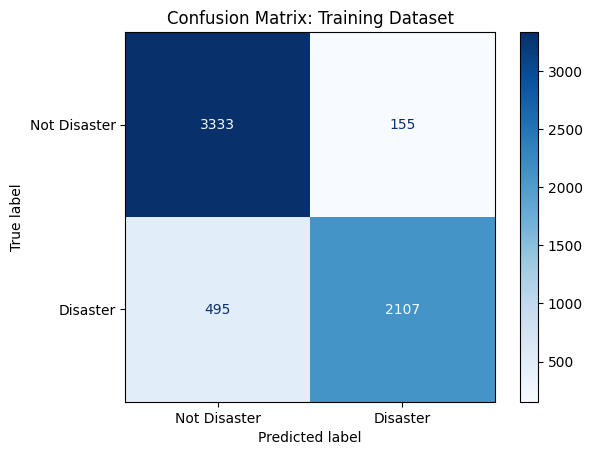

In [ ]:
display = ConfusionMatrixDisplay.from_predictions(
    y_train,
    np.argmax(y_train_pred, axis=1),
    display_labels=["Not Disaster", "Disaster"],
    cmap=plt.cm.Blues
)
display.ax_.set_title("Confusion Matrix: Training Dataset")

tn, fp, fn, tp = confusion_matrix(y_train, np.argmax(y_train_pred, axis=1)).ravel()
f1_score = 2 * tp / (2 * tp + fp + fn)


print("F1 score:", f1_score)


Successivamente abbiamo creato la matrice di confusione, confrontando le etichette vere (y_train) con quelle predette.

np.argmax(y_train_pred, axis=1) converte le predizioni in etichette finali, prendendo l’indice della classe con probabilità più alta (0 o 1).

display_labels specifica le etichette leggibili da mostrare sull’asse X e Y della matrice.

cmap=plt.cm.Blues imposta la colorazione del grafico: più il quadrante ha valore alto, più sarà scuro.

Andiamo a calcolare manualmente F1 Score.


L’F1 score è una metrica molto utile perché bilancia precisione e richiamo (recall), ed è particolarmente rilevante nei problemi con classi squilibrate.



#### Risultati
La confusion matrix presenta:


*   VP = 2107
*   VN = 3333
*   FP = 155 (errore di primo tipo)
*   FN = 495 (errore di secondo tipo)







In [ ]:
y_val_pred = classifier.predict(X_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step


In [ ]:
print(y_val_pred)

[[ 1.0452145 -0.7981396]
 [ 1.08362   -0.7701783]
 [-0.7998097  1.1214424]
 ...
 [-1.6597382  1.7063662]
 [-1.7884129  1.8638736]
 [-0.5050022  0.5624976]]


F1 score: 0.7944078947368421


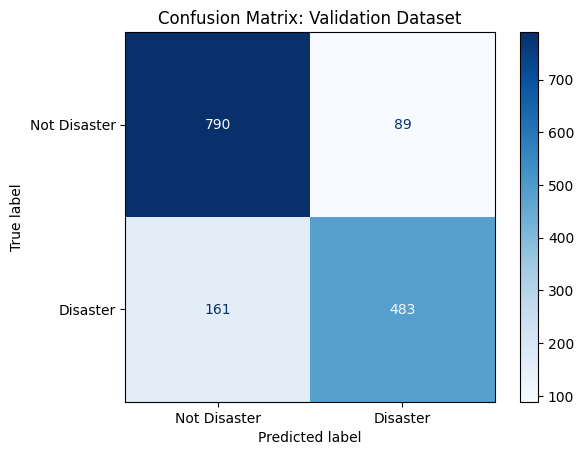

In [ ]:
display = ConfusionMatrixDisplay.from_predictions(
    y_val,
    np.argmax(y_val_pred, axis=1),
    display_labels=["Not Disaster", "Disaster"],
    cmap=plt.cm.Blues
)
display.ax_.set_title("Confusion Matrix: Validation Dataset")

tn, fp, fn, tp = confusion_matrix(y_val, np.argmax(y_val_pred, axis=1)).ravel()
f1_score = 2 * tp / (2 * tp + fp + fn)


print("F1 score:", f1_score)

Il risultato ci mostra che il modello ha un F1 score = 0.769. In più mostra La matrice:


*   VP = 483
*   VN = 790
*   FP = 89
*   FN = 161



In [ ]:
try:
  from google.colab import files
  g_colab= True
except:
  g_colab = False


import pandas as pd
import numpy

file_name = "../train.csv"

if g_colab:
  uploaded = files.upload()
  import io
  uploaded_bytes = uploaded[list(uploaded.keys())[0]]
  sample_submission = pd.read_csv(io.BytesIO(uploaded_bytes))
else:
  sample_submission = pd.read_csv(file_name)


sample_submission

Saving sample_submission.csv to sample_submission.csv


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [ ]:

sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

sample_submission.to_csv("submission.csv", index=False)


102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 324ms/step


Siamo nella fase finale del flusso di lavoro, in cui il modello viene usato per generare predizioni sul set di test e creare un file submission.csv pronto per essere inviato.
Il sample_submission è un file CSV che contiene una colonna id e una colonna target vuota o precompilata.

sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)
Questa riga applica il modello classifier per fare predizioni sul dataset X_test, che contiene i testi puliti del set di test.
classifier.predict(X_test) restituisce per ogni testo un array di due valori (uno per classe).


Questi valori vengono assegnati alla colonna "target" del sample_submission, sovrascrivendo (o creando) quella colonna con le predizioni del modello.

In seguito andiamo a creare un file CSV chiamato submission.csv contenente i dati del DataFrame sample_submission, senza l’indice numerico.






